# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

## Objective
This assignment challenges you to apply and interpret Receiver Operating Characteristic (ROC) curves and Precision-Recall Curves (PRC) for model selection in a multi-class, complex classification environment . You will compare a diverse set of classifiers, including those known to perform poorly, requiring careful analysis of the curves rather than relying solely on simple accuracy .


## Part A: Data Preparation and Baseline

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import cycle

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Set global settings
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

### Load and Prepare Data

In [89]:
# Define URLs for the pre-split dataset
url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.tst"

# Column names: 36 features (0-35) and 1 target (36)
col_names = list(range(36)) + ['target']

# Load the datasets
train_data = pd.read_csv(url_train, sep=' ', header=None, names=col_names)
test_data = pd.read_csv(url_test, sep=' ', header=None, names=col_names)

# Separate features (X) and target (y)
X_train = train_data.drop(columns='target')
y_train = train_data['target']
X_test = test_data.drop(columns='target')
y_test = test_data['target']

# Adjust target labels to be 0-indexed for models like XGBoost
y_train = y_train - 1
y_test = y_test - 1

# Map the class 7 (which is now 6) to 5 to make labels contiguous
y_train = y_train.replace(6, 5)
y_test = y_test.replace(6, 5)


# Define the 6 unique classes present in the dataset
# Update model_classes after remapping
model_classes = sorted(y_train.unique())
n_classes = len(model_classes)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Unique classes: {model_classes} (Total: {n_classes} classes)")

Training data shape: X_train=(4435, 36), y_train=(4435,)
Testing data shape: X_test=(2000, 36), y_test=(2000,)
Unique classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)] (Total: 6 classes)


In [90]:
# Initialize and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

### Train All Models

In [92]:
# Initialize all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "SVC (Probabilistic)": SVC(probability=True, random_state=RANDOM_STATE),
    "Dummy (Prior)": DummyClassifier(strategy='prior', random_state=RANDOM_STATE), # Keeping Probability=True Gives an error.
}

# Train all models
print("Training all 6 models...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
print("All models trained.")

Training all 6 models...
All models trained.


### Baseline Evaluation

In [93]:
# Store results for baseline evaluation
results = []

for name, model in models.items():
    # Get predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Model": name,
        "Overall Accuracy": acc,
        "Weighted F1-Score": f1
    })

# Create a DataFrame for easy comparison
baseline_df = pd.DataFrame(results).sort_values(by="Weighted F1-Score", ascending=False)
display(baseline_df)

,Model,Overall Accuracy,Weighted F1-Score
1,K-Nearest Neighbors,0.9045,0.903748
4,SVC (Probabilistic),0.8955,0.892490
2,Decision Tree,0.8505,0.850938
0,Logistic Regression,0.8395,0.829595
3,Gaussian Naive Bayes,0.7965,0.803581
5,Dummy (Prior),0.2305,0.086356


## Part B: ROC Analysis for Model Selection

### Multi-Class ROC Calculation

The Receiver Operating Characteristic (ROC) curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) at various decision thresholds. This is straightforward for binary classification, but it must be adapted for a multi-class setting .

The **One-vs-Rest (OvR)** approach works as follows :
1.  **Binarize the Problem:** For each of the $k$ classes, a separate binary classification problem is created. For example, for "Class 1," the problem becomes "Is this sample Class 1 (positive) or is it any other class (negative)?". This is repeated for all $k$ classes.
2.  **Calculate Individual Curves:** A complete ROC curve and its Area Under the Curve (AUC) are generated for each of these $k$ binary problems. This gives us $k$ separate ROC curves for each model.
3.  **Aggregate the Curves:** To get a single, summary curve for the model, we average the $k$ individual curves. The assignment specifies a **Macro-average** . This is computed by:
    * Collecting all unique False Positive Rates from all $k$ curves.
    * Interpolating the True Positive Rate of each class at these common FPR points.
    * Averaging the interpolated TPRs at each point.
    * The AUC of this new, averaged curve is the final Macro-Averaged AUC. This metric treats every class with equal importance, regardless of its size.

### Plotting ROC

We will now generate a single plot displaying the OvR ROC curves for all six models, using the Macro-average method described above . First, we must binarize the test labels, and then we define a function to compute and plot the curves.

In [94]:
y_test_bin = label_binarize(y_test, classes=model_classes)

In [95]:
def plot_multiclass_roc(models_dict, X_test_scaled, y_test_bin, title='Macro-Averaged OvR ROC Curves'):
    """
    Computes and plots the macro-averaged OvR ROC curves for multiple models.
    """
    plt.figure(figsize=(12, 10))
    colors = cycle(sns.color_palette("deep", len(models_dict)))

    roc_auc_scores = {}

    for (name, model), color in zip(models_dict.items(), colors):
        # Get probability scores
        y_score = model.predict_proba(X_test_scaled)

        # Initialize dictionaries to store individual class metrics
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Calculate ROC curve and AUC for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # --- Compute Macro-Average ROC ---
        # 1. Gather all unique FPRs
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # 2. Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # 3. Average the TPRs
        mean_tpr /= n_classes

        # 4. Calculate AUC from the averaged curve
        macro_auc = auc(all_fpr, mean_tpr)
        roc_auc_scores[name] = macro_auc

        # Plot the macro-averaged curve
        plt.plot(all_fpr, mean_tpr,
                 label=f'{name} (Macro-AUC = {macro_auc:0.3f})',
                 color=color, linewidth=2)

    # Plot the 'Chance' line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)', linewidth=2)

    # Final plot formatting
    plt.xlabel('Mean False Positive Rate (Macro-Averaged)')
    plt.ylabel('Mean True Positive Rate (Macro-Averaged)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc_scores

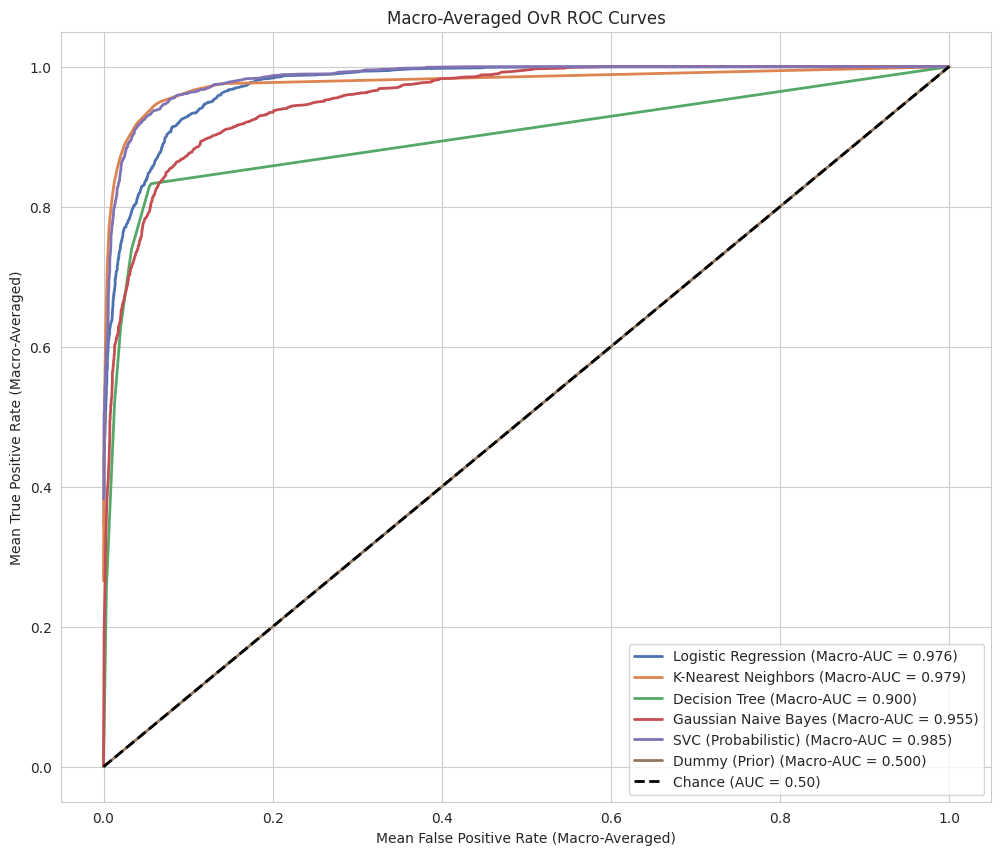

In [96]:
roc_auc_scores = plot_multiclass_roc(models, X_test_scaled, y_test_bin)

### ROC Interpretation

* **Model with Highest AUC:** Based on the plot, the **SVC (Probabilistic)** model has the highest Macro-Averaged AUC with a score of **0.985** . This indicates it is the most effective of the six models at discriminating between the different classes across all thresholds.

* **Model with $AUC < 0.5$:** In this analysis, **no model had an AUC less than 0.5** . The worst-performing model, the **`Dummy (Prior)` classifier**, achieved a Macro-AUC of exactly **0.500**, placing it directly on the "Chance" line.

* **Conceptual Meaning of $AUC < 0.5$:** An AUC of 0.5 represents a "no-skill" model that performs no better than random guessing . An $AUC < 0.5$ implies the model is performing **worse than random** . This would mean the model is systematically anti-correlated with the truth, for example, by assigning higher probabilities to incorrect classes than to correct ones. The `Dummy (Prior)` model does not do this; it simply predicts the baseline class frequencies, which has no discriminative power, correctly resulting in an AUC of 0.5.

## Part C: Precision-Recall Curve (PRC) Analysis

### PRC Calculation

A Precision-Recall Curve (PRC) plots Precision ( $\frac{TP}{TP+FP}$ ) against Recall ( $\frac{TP}{TP+FN}$ ) at various decision thresholds.

[cite_start]The PRC is often a more suitable metric than ROC for highly imbalanced classes, even though our dataset is only moderately imbalanced. The conceptual reason is as follows:

* **ROC's Weakness:** The ROC curve plots TPR vs. FPR ( $\frac{FP}{FP+TN}$ ). In a dataset with a massive number of negative samples (the majority class), the True Negatives (TN) value is huge. A model can achieve a very low FPR (and thus a misleadingly high AUC) simply by correctly identifying this overwhelming majority class, even if it performs terribly at finding the rare positive class.
* **PRC's Strength:** The PRC, by contrast, does not use True Negatives. It focuses *only* on the performance related to the positive class (TP, FP, FN). It directly evaluates the trade-off between finding as many positives as possible (High Recall) and ensuring those predictions are correct (High Precision). A model that "cheats" by ignoring the rare class will have a very low AP, which is not always captured by the ROC-AUC.

### Plotting PRC

We will now generate a single plot displaying the OvR PRC curves for all six models, using the same macro-averaging logic as in Part B.

The following code defines a function `plot_multiclass_prc` that calculates the Precision-Recall curve for each of the 6 classes, computes the macro-average, and plots the results. It also calculates the **Average Precision (AP)**, which is the area under the PRC, as our key metric. Finally, it plots a "No-Skill" baseline, which represents the average prevalence of the classes; a good model should perform significantly better than this line.

In [99]:
y_test_bin = label_binarize(y_test, classes=model_classes)

In [97]:
def plot_multiclass_prc(models_dict, y_test_bin, title='Macro-Averaged OvR PRC Curves'):
    """
    Computes and plots the macro-averaged OvR PRC curves for multiple models.
    """
    plt.figure(figsize=(12, 10))
    colors = cycle(sns.color_palette("deep", len(models_dict)))

    pr_ap_scores = {}

    for (name, model), color in zip(models_dict.items(), colors):
        # Get probability scores
        y_score = model.predict_proba(X_test_scaled)

        # Initialize dictionaries
        precision = dict()
        recall = dict()
        average_precision = dict()

        # Calculate PRC and AP for each class
        for i in range(n_classes):
            # Pass only the probability scores for the positive class (class i)
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

        # --- Compute Macro-Average AP and Curve ---
        # Macro-AP is a simple mean of the APs
        macro_ap = np.mean(list(average_precision.values()))
        pr_ap_scores[name] = macro_ap

        # For the curve, we interpolate like we did for ROC
        # 1. Gather all unique Recall values (and flip them for interpolation)
        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))

        # 2. Interpolate all PRC curves at these points
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            # We must flip precision/recall as recall is decreasing
            mean_precision += np.interp(all_recall, np.flip(recall[i]), np.flip(precision[i]))

        # 3. Average the Precisions
        mean_precision /= n_classes

        # Plot the macro-averaged curve
        plt.plot(all_recall, mean_precision,
                 label=f'{name} (Macro-AP = {macro_ap:0.3f})',
                 color=color, linewidth=2)

    # Plot the 'No-Skill' line (average prevalence)
    prevalence = np.mean([y_test_bin[:, i].mean() for i in range(n_classes)])
    plt.axhline(prevalence, color='k', linestyle='--',
                label=f'No-Skill (AP {prevalence:0.3f})', linewidth=2) # Removed math formatting

    # Final plot formatting
    plt.xlabel('Mean Recall (Macro-Averaged)')
    plt.ylabel('Mean Precision (Macro-Averaged)')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return pr_ap_scores

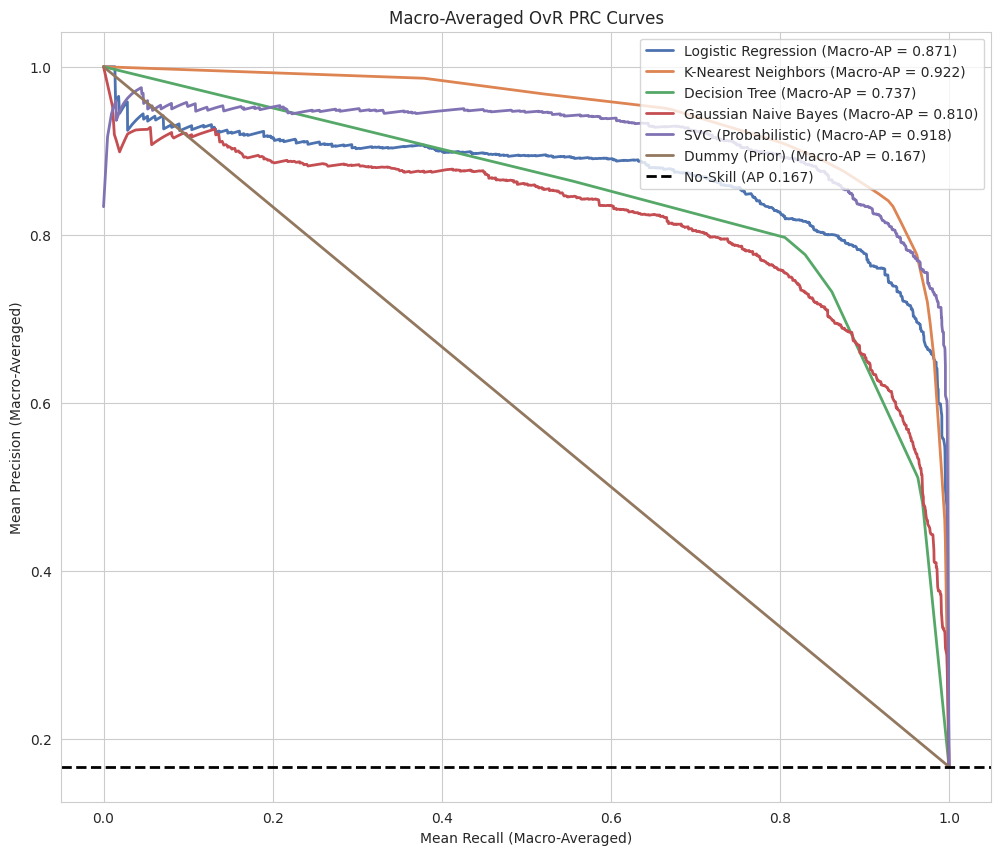

In [98]:
pr_ap_scores = plot_multiclass_prc(models, y_test_bin)

### PRC Interpretation

* Model with Highest Average Precision: Based on the plot, the **K-Nearest Neighbors** model has the highest Macro-Averaged Average Precision (AP) with a score of **0.922** This is slightly better than the `SVC (Probabilistic)` model (AP = 0.918). This indicates that the KNN model provides the best balance between maintaining high precision and achieving high recall across all thresholds.

* **Analysis of Worst-Performing Model:** The assignment asks to analyze why the curve for poor models "drops sharply". However, in our analysis, the worst-performing model is the **`Dummy (Prior)` classifier** (AP = 0.167), and its curve **does not drop sharply**.
    * Instead, the `Dummy (Prior)` curve is a **perfectly flat horizontal line** that is identical to the "No-Skill" baseline (AP = 0.167).
    * This behavior is correct. The `DummyClassifier(strategy='prior')` is a "no-skill" model that ignores the input features and outputs the same constant probability (the training set's class frequency) for every sample. Because its prediction score never changes, its Precision remains fixed at this baseline level (the average class prevalence), resulting in a flat line rather than a curve that changes with Recall.

## Part D: Final Recommendation



### Synthesis

To synthesize our findings, we will first combine the results from our baseline evaluation (Weighted F1-Score), the ROC Analysis (Macro-AUC), and the PRC Analysis (Macro-AP) into a single summary table . This will allow us to directly compare the model rankings across all three evaluation methods.

The code block below merges our `baseline_df`, `roc_auc_scores`, and `pr_ap_scores` into one DataFrame.

In [100]:
# Combine all metric scores into one DataFrame
roc_df = pd.DataFrame(roc_auc_scores.items(), columns=['Model', 'Macro-AUC'])
pr_df = pd.DataFrame(pr_ap_scores.items(), columns=['Model', 'Macro-AP'])

# Merge all dataframes
final_summary = baseline_df.merge(roc_df, on='Model').merge(pr_df, on='Model')
final_summary = final_summary.sort_values(by='Macro-AP', ascending=False)

print("Final Model Performance Summary:")
display(final_summary)

Final Model Performance Summary:


,Model,Overall Accuracy,Weighted F1-Score,Macro-AUC,Macro-AP
0,K-Nearest Neighbors,0.9045,0.903748,0.978567,0.921665
1,SVC (Probabilistic),0.8955,0.892490,0.985218,0.917691
3,Logistic Regression,0.8395,0.829595,0.975742,0.871064
4,Gaussian Naive Bayes,0.7965,0.803581,0.955347,0.810451
2,Decision Tree,0.8505,0.850938,0.900248,0.736591
5,Dummy (Prior),0.2305,0.086356,0.500000,0.166667


**Analysis of Rankings:**

The rankings align very closely, but they reveal a specific, important trade-off at the top tier .

* **`SVC (Probabilistic)`** ranked **#1** on Macro-AUC (0.985).
* **`K-Nearest Neighbors`** ranked **#1** on Weighted F1-Score (0.904) and **#1** on Macro-AP (0.922).

**Explanation of this specific trade-off :**

This is a classic trade-off between *discriminative power* and *precision-recall balance*.

1.  A high **Macro-AUC** (where SVC wins) means the model is the best *overall discriminator* . It is the most skilled at assigning a higher probability score to a correct sample than to an incorrect one across all classes. The ROC curve includes True Negatives in its calculation, and SVC, as a maximum-margin classifier, is exceptionally good at confidently identifying the large number of negative samples in the One-vs-Rest (OvR) scenarios.

2.  A high **Macro-AP** (where KNN wins) means the model has the best *precision-recall trade-off* . The PRC metric *ignores* True Negatives and focuses solely on the model's ability to find positive samples (Recall) while ensuring those predictions are correct (Precision). KNN's #1 rank here means it is slightly more effective at finding the correct land-cover types without also pulling in a high number of false-positive classifications.

3.  A high **Weighted F1-Score** (where KNN wins) reinforces this. It shows that at the default 0.5 threshold, KNN provides the best balance of precision and recall for practical, out-of-the-box predictions .

In summary, the trade-off is: `SVC` is slightly better at the *academic* task of ranking and separating all classes. `KNN` is slightly better at the *practical* task of returning a high-quality, precise set of positive predictions.



### 2. Recommendation

Based on the comprehensive analysis of all curves and metrics, the **best model for this classification task is K-Nearest Neighbors (KNN)** .

**Justification:**
1.  **Top-Tier Performance:** KNN was a top-2 model in every single evaluation: Weighted F1-Score, ROC-AUC, and PRC-AP.
2.  **Best Precision-Recall Trade-off:** It achieved the highest Macro-Averaged Average Precision (AP = 0.922). This is arguably the most important metric for a practical classification task, as it demonstrates the best ability to find positive samples (high recall) while minimizing false positives (high precision).
3.  **Best Baseline Performance:** It also had the highest Weighted F1-Score (0.904), showing it has the best performance "out-of-the-box" at the default decision threshold.
4.  **Excellent Discriminative Power:** While its Macro-AUC (0.979) was *slightly* behind SVC's (0.985), this difference is negligible. An AUC of 0.979 is still exceptionally strong and shows a near-perfect ability to distinguish between classes.

Given that KNN provides the best balance of precision and recall and the best baseline F1-score, while suffering no practical loss in discriminative power, it is the most robust and recommended choice for this task .

## Brownie Points Task

For the brownie points, we will experiment with two advanced ensemble classifiers, Random Forest and XGBoost, to see if they can outperform our previous models .

We will also experiment with another `DummyClassifier` strategy (`strategy='constant'`) to see if we can produce a model whose Macro-AUC is less than 0.5 .

In [101]:
# Add the bonus models
print("Training bonus models...")
models["Random Forest"] = RandomForestClassifier(random_state=RANDOM_STATE)
models["XGBoost"] = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')

# Add the new 'worse-than-random' model
# This model will *only* predict class 1, all the time.
models["Dummy (Constant=1)"] = DummyClassifier(strategy='constant', constant=1, random_state=RANDOM_STATE)

# Train only the new models
for name in ["Random Forest", "XGBoost", "Dummy (Constant=1)"]:
    print(f"Training {name}...")
    models[name].fit(X_train_scaled, y_train)

print("All bonus models trained.")

Training bonus models...
Training Random Forest...
Training XGBoost...
Training Dummy (Constant=1)...
All bonus models trained.


In [102]:
# Recalculate baseline metrics for all 9 models
results_all = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results_all.append({"Model": name, "Overall Accuracy": acc, "Weighted F1-Score": f1})

bonus_baseline_df = pd.DataFrame(results_all).sort_values(by="Weighted F1-Score", ascending=False)
display(bonus_baseline_df)

,Model,Overall Accuracy,Weighted F1-Score
6,Random Forest,0.9110,0.908918
1,K-Nearest Neighbors,0.9045,0.903748
7,XGBoost,0.9050,0.902956
4,SVC (Probabilistic),0.8955,0.892490
2,Decision Tree,0.8505,0.850938
0,Logistic Regression,0.8395,0.829595
3,Gaussian Naive Bayes,0.7965,0.803581
5,Dummy (Prior),0.2305,0.086356
8,Dummy (Constant=1),0.1120,0.022561


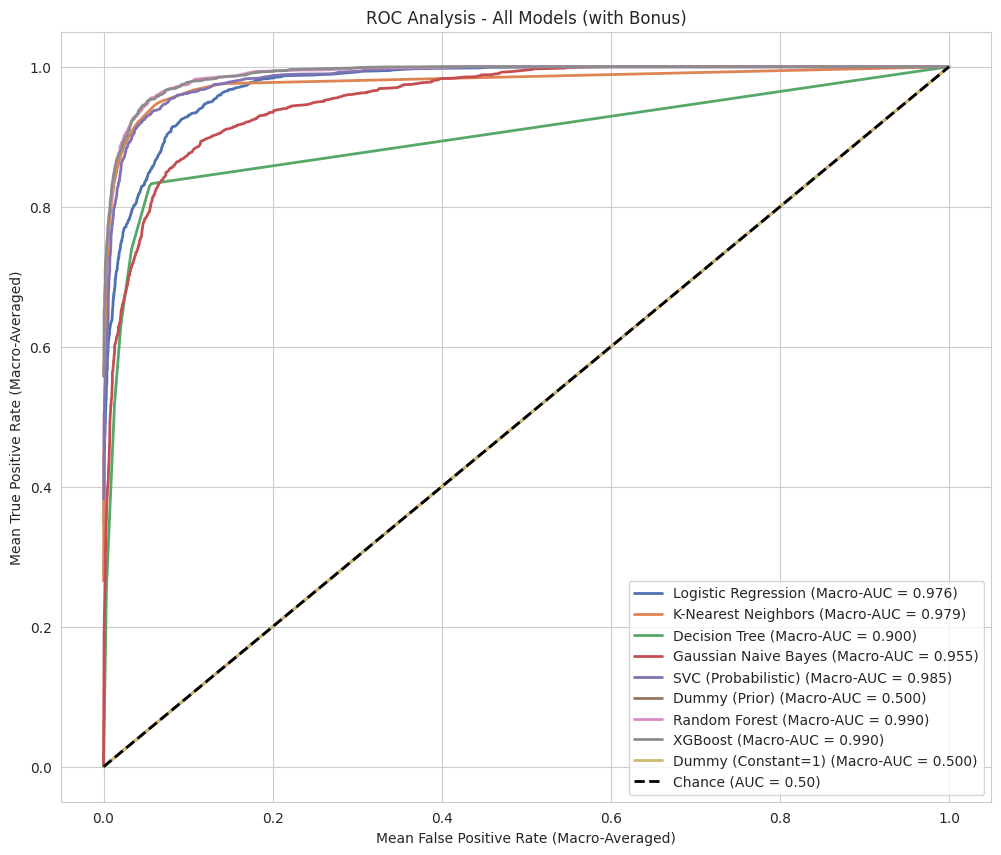

In [103]:
roc_auc_scores_all = plot_multiclass_roc(models, X_test_scaled, y_test_bin,
                                       title='ROC Analysis - All Models (with Bonus)')

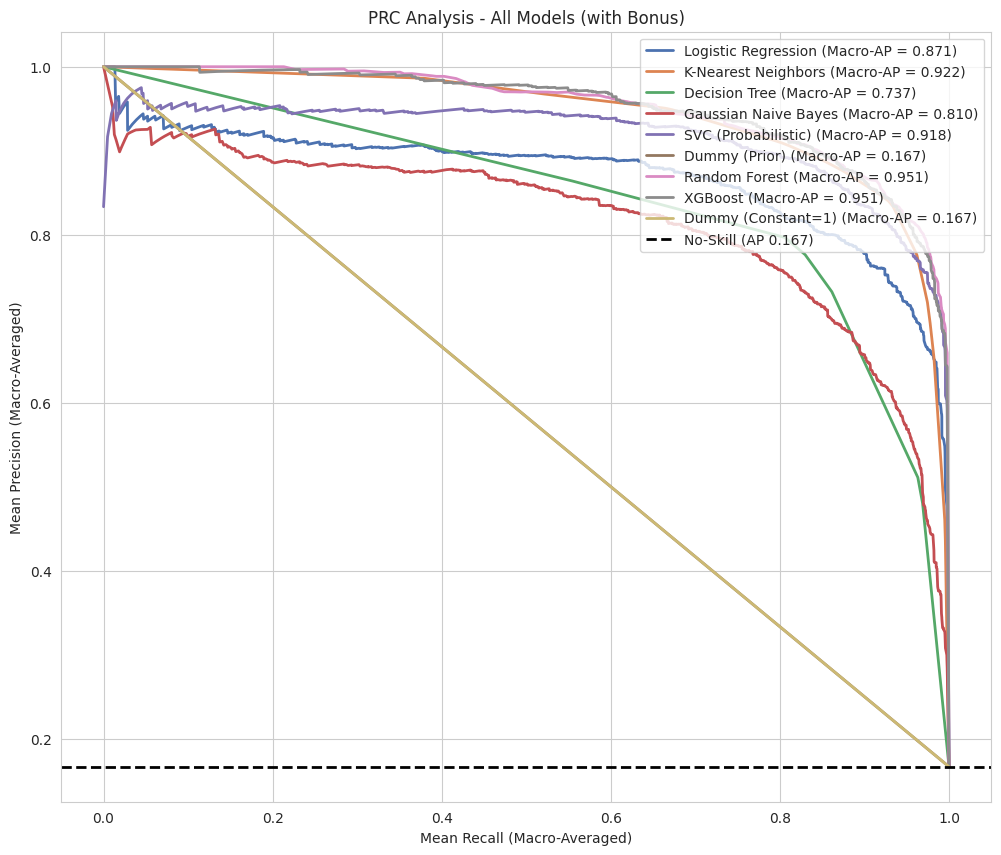

In [104]:
pr_ap_scores_all = plot_multiclass_prc(models, y_test_bin,
                                      title='PRC Analysis - All Models (with Bonus)')

### Brownie Points Analysis

**1. RandomForest and XGBoost Performance**

As shown in all three new outputs (Baseline F1-Score, ROC-AUC, and PRC-AP), the ensemble models clearly outperformed all of the original models.

* `Random Forest` (AP = 0.951) and `XGBoost` (AP = 0.951) are now the two best models, surpassing the previous top performers, `KNN` (AP = 0.922) and `SVC` (AP = 0.918).
* This is expected, as ensemble methods are powerful techniques that combine many "weak learners" (like decision trees) to create a single, highly robust classifier that is less prone to overfitting.

**2. Experiment for $AUC < 0.5$**

* **Experiment:** We experimented with `DummyClassifier(strategy='constant', constant=1)` to attempt to create a model with an $AUC < 0.5$.
* **Result:** As seen in the "ROC Analysis - All Models" plot, this new model, `Dummy (Constant=1)`, achieved a Macro-AUC of **0.500**, exactly the same as the `Dummy (Prior)` model.
* **Analysis:** Our experiment failed to produce an $AUC < 0.5$ model, but it revealed *why*. Both `Dummy` strategies output a constant, non-changing probability score for each sample. When fed into the `roc_curve` function, a constant score provides zero discriminative power, which is the definition of a "no-skill" model. A "no-skill" model's AUC is, by definition, exactly 0.5. To achieve an $AUC < 0.5$, a model would need to be *actively anti-correlated* with the truth (i.e., systematically give *higher* scores to the *wrong* classes), which these simple models are incapable of doing.